In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
import utils as data_utils

###------------------------------------
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.express as px
from matplotlib import cm
### PCA plotting


### Machine Learning sites
# https://github.com/taspinar/siml/blob/master/notebooks/Machine%20Learning%20with%20Signal%20Processing%20techniques.ipynb

### Data Import Experiment

In [2]:
Freq=np.arange(0.06,0.36,0.01)*1e3
Brust=5/(Freq*1e-3)
Fss=2
#------------------# velocity calculated
Velocity=pd.read_csv('EnergyVelocity.txt', skiprows=4, delimiter=';')
Freq_velocity=np.linspace(0.05,0.4,500)*1e3
print(Velocity.shape)
Velo_A0=Velocity[Velocity.keys()[1]]
fA0 = interpolate.interp1d(Freq_velocity, Velo_A0)(Freq)


(500, 3)


In [3]:
def norm(x):
    return x/np.amax(abs(x), axis=-1, keepdims=True)

In [4]:
Exp_P=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_Hole_DATA.npy')
Exp_D=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_CRACKLENGTH_DATA.npy')
Exp_T=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_TimeVector.npy')
Exp_CL=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_CrackLengthInput.npy')
Nend=327
Exp_T_w_row=Exp_T[:Nend]
Exp_P_w_row_t=norm(data_utils.window_Matrix_function(Exp_P[...,:Nend],Brust,fA0,Fss)) # Number of Time domain
Exp_D_w_row_t=norm(data_utils.window_Matrix_function(Exp_D[...,:Nend],Brust,fA0,Fss))


6
6


In [5]:
print(Exp_P_w_row_t.shape)

(30, 1, 12, 4, 4, 327)


In [6]:
def labelling(A, repeat_time=1):
    Y_label=np.empty_like(A, dtype=int)
    for n_ in range(A.shape[1]):
        for n_cl in range(A.shape[0]):
            if A[n_cl,n_] <=5.0:
                Y_label[n_cl,n_ ]=1

            elif A[n_cl,n_] >5.0 and A[n_cl,n_] <=10.0:
                Y_label[n_cl,n_ ]=2
        
            elif A[n_cl,n_] >10.0 and A[n_cl,n_] <=15.0:
                Y_label[n_cl,n_ ]=3
        
            elif A[n_cl,n_] >15.0 and A[n_cl,n_] <=20.0:
                Y_label[n_cl,n_ ]=4
            
            elif A[n_cl,n_] >20.0 and A[n_cl,n_] <=25.0:
                Y_label[n_cl,n_ ]=5
            
            elif A[n_cl,n_] >25.0 and A[n_cl,n_] <=30.0:
                Y_label[n_cl,n_ ]=6
        
            else:
                 Y_label[n_cl,n_ ]=7
    return Y_label


In [7]:
bool_E=np.array([0,2])
bool_R=np.array([1,3])
Exp_P_w_row=Exp_P_w_row_t[4,:,:,bool_E,bool_R,:299]
Exp_D_w_row=Exp_D_w_row_t[4,:,:,bool_E,bool_R,:299]

In [8]:
print(Exp_P_w_row.shape)
print(Exp_D_w_row.shape)

(2, 1, 12, 299)
(2, 21, 12, 299)


In [9]:
simFrequency=100
index=np.argmin(abs(Freq-simFrequency))
print("Simulation Excitation frequency is =",Freq[index])
Sim_P=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_Hole_DATA.npy')
Sim_D=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_CRACKLENGTH_DATA.npy')
Sim_T=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_TimeVector.npy').T
Sim_CL=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_CrackLengthInput.npy')
Sim_P_w_row=(data_utils.window_Matrix_function(Sim_P,[Brust[index]],[fA0[index]],Fss)) # Number of Time domain
Sim_D_w_row=(data_utils.window_Matrix_function(Sim_D,[Brust[index]],[fA0[index]],Fss))
Sim_D_w_row=Sim_D_w_row[0,:,:,bool_E,bool_R,:]
Sim_P_w_row=Sim_P_w_row[0,:,:,bool_E,bool_R,:]

Simulation Excitation frequency is = 99.99999999999997
6
6


In [10]:
print(Sim_P_w_row.shape)
print(Sim_D_w_row.shape)

(2, 1, 99, 299)
(2, 20, 99, 299)


#### Data for training

In [11]:
Exp_Y_label=labelling(Exp_CL)
Sim_Y_label=labelling(Sim_CL)

In [23]:
Exp_P_w_F=Exp_P_w_row.reshape(np.prod(np.asarray(Exp_P_w_row.shape[:-1])),Exp_P_w_row.shape[-1])
Exp_D_w_F=Exp_D_w_row.reshape(np.prod(np.asarray(Exp_D_w_row.shape[:-1])),Exp_D_w_row.shape[-1])
print('experiment-pristine-shape={}'.format(Exp_P_w_F.shape))
print('experiment-damage-shape={}'.format(Exp_D_w_F.shape))

# flatten the array for training the model
Sim_P_w_F=Sim_P_w_row.reshape(np.prod(np.asarray(Sim_P_w_row.shape[:-1])),Sim_P_w_row.shape[-1])
Sim_D_w_F=Sim_D_w_row.reshape(np.prod(np.asarray(Sim_D_w_row.shape[:-1])),Sim_D_w_row.shape[-1])
print('simulation-pristine-shape={}'.format(Sim_P_w_F.shape))
print('simulation-damage-shape={}'.format(Sim_D_w_F.shape))

y_P_exp=np.zeros(Exp_P_w_F.shape[0], dtype=int)#
y_D_exp=np.repeat(Exp_Y_label.flatten(),bool_E.shape)
# y_D_exp=np.ones(Exp_D_w_F.shape[0],dtype=int)
y_P=np.zeros(Sim_P_w_F.shape[0], dtype=int)#
y_D=np.repeat(Sim_Y_label.flatten(),bool_E.shape)

X=np.concatenate((Exp_P_w_F,Exp_D_w_F))#((Sim_P_w_F,Sim_D_w_F))
Y=np.concatenate((y_P_exp,y_D_exp))#((y_P,y_D))#



# X=np.concatenate((Exp_P_w_F,Exp_D_w_F))
# Y=np.concatenate((y_P_exp,y_D_exp))
print("X shape={}".format(X.shape))
print("Y shape={}".format(Y.shape))
# Y_demo=np.concatenate((y_P,Sim_CL.ravel()))
# Y_demo

experiment-pristine-shape=(24, 299)
experiment-damage-shape=(504, 299)
simulation-pristine-shape=(198, 299)
simulation-damage-shape=(3960, 299)
X shape=(528, 299)
Y shape=(528,)


In [24]:
# Normlizaizng the data for PCA is necessary
X_norm=StandardScaler().fit(X).transform(X)
plt.style.use("E:\Thesis_writting\Final_thesis_code\Plotting\\science_plot.mplstyle")
# applied the PCA on traning sets and then map to the train
n_components = 8
pca=PCA(n_components=n_components).fit(X_norm)
total_var = pca.explained_variance_ratio_.sum() * 100
print("total_var={}".format(total_var))
X_pca=pca.transform(X_norm)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
fig = px.scatter_matrix(
    X_pca,
    labels=labels,
    dimensions=range(3),
    color=Y
)
fig.update_traces(diagonal_visible=False)
fig.show()
# fig.savefig(r"E:\\PPT\\Job\\Unity_sc\\"+'PCA_'+ '.png', dpi=600, transparent=False, bbox_inches='tight')
Data_PCA=pd.DataFrame(X_pca, columns=["PCA_"+str(i) for i in range(n_components)])
Data_PCA['Class']=Y
Data_PCA.to_csv("Data_PCA_exp.csv")
# Data_PCA

total_var=99.38794213029973


# t-SNE

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3,random_state = 0,n_iter=300)

X_tsne =tsne.fit_transform(X_norm)
# Data_TSNE=pd.DataFrame(X_tsne, columns=["TSNE_"+str(i) for i in range(n_components)])
X_tsne.shape

fig = px.scatter_matrix(
    X_tsne,
    labels=['t1','t2','3'],
    dimensions=range(3),
    color=Y
)
fig.update_traces(diagonal_visible=False)
fig.show()

# Data Splitting

In [15]:
max(Y)

6

In [16]:
from sklearn.preprocessing import label_binarize
Y_OvA = label_binarize(Y, classes=np.arange(0, max(Y)))
n_classes = Y_OvA.shape[1]

In [17]:
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X_pca.shape
X_pca_noise = np.c_[X_pca, random_state.randn(n_samples, 200 * n_features)]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, random_state=0, test_size=0.75)

Support vector machine classifier (linear kernel, C=1)
 [[ 0  3  4  3  5  6  0]
 [ 0 18 18  0  2 13  0]
 [ 0  5 61  2  4  4  0]
 [ 0  1 29 13  6 22  0]
 [ 0  2  5  6 26 22  0]
 [ 0  0  5  0  3 48  2]
 [ 0  0  3  2  3 45  5]]


NameError: name 'accuracy_score' is not defined

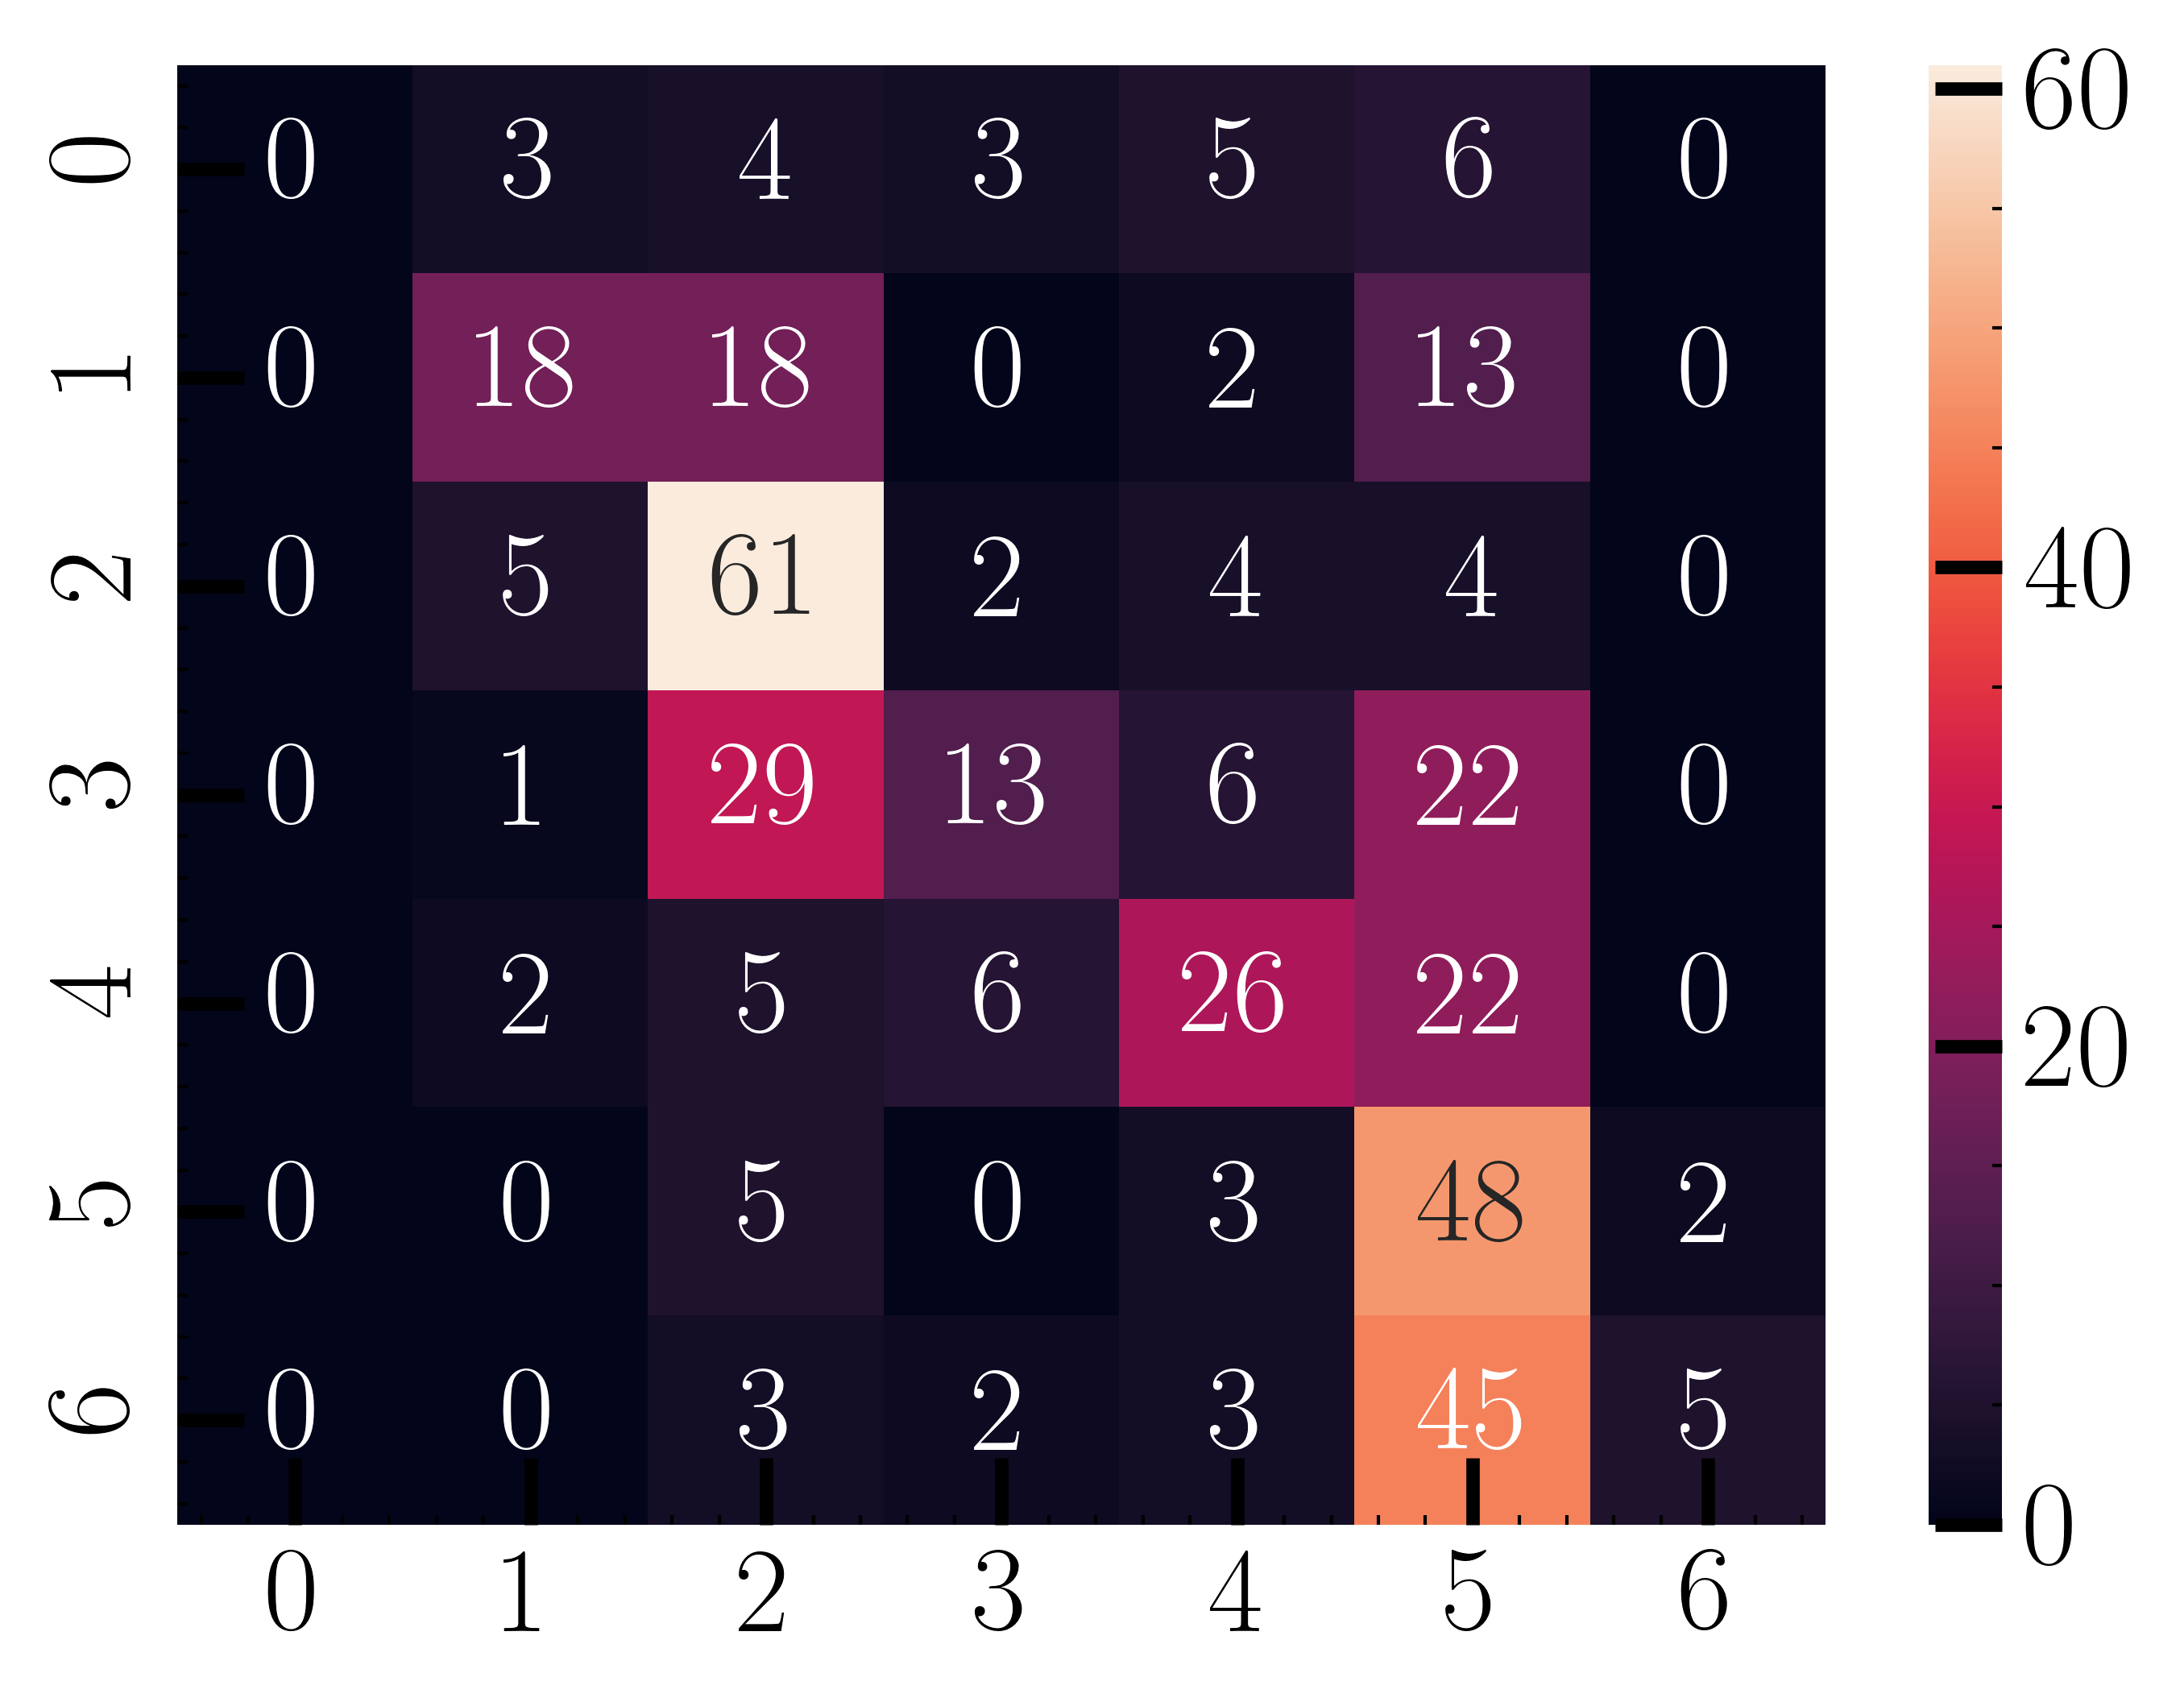

In [19]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
#DecisionTreeClassifier(max_depth=100).fit(Z_train, y_train)#
svm =  SVC(kernel='rbf', C=1,gamma=0.2).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)
confusion = confusion_matrix(y_test, svm_predicted)

df_cm=pd.DataFrame(confusion, index=[i for i in range(0,7)],columns=[i for i in range(0,7)] )
print('Support vector machine classifier (linear kernel, C=1)\n', confusion)
# svm.score(Y_test, y_test)
plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       svm_predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_predicted)))
# print('Precision: {:.2f}'.format(precision_score(y_test, svm_predicted)))
# print('Recall: {:.2f}'.format(recall_score(y_test, svm_predicted)))
# print('F1: {:.2f}'.format(f1_score(y_test, svm_predicted)))


In [ ]:
# Combined report with all above metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_predicted))

In [ ]:
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, svm_predicted, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, svm_predicted, average = 'macro')))

In [ ]:
print('Micro-averaged f1 = {:.2f} (treat instances equally)'
      .format(f1_score(y_test, svm_predicted, average = 'micro')))
print('Macro-averaged f1 = {:.2f} (treat classes equally)'
      .format(f1_score(y_test, svm_predicted, average = 'macro')))

In [ ]:
y_scores_lr = svm.fit(X_train, y_train).decision_function(y_test)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test,y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
# plt.axes().set_aspect('equal')
# plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
     

In [ ]:
from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier(n_neighbors = 5)
cv_scores = cross_val_score(clf, X_train, y_train)

print('Cross-validation scores (3-fold):', cv_scores)
print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf =SVC(kernel = 'rbf', C=0.01).fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
cv_scores = cross_val_score(clf, X_train, y_train,cv=3)

print('Cross-validation scores (3-fold):', cv_scores)
print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))


In [ ]:
from sklearn.svm import SVC
this_C = 0.01
clf = SVC(kernel = 'rbf', C=this_C).fit(X_train, y_train)
title = 'Linear SVC, C = {:.3f}'.format(this_C)
print('Breast cancer dataset')
print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

In [ ]:
# Number of rows = Number of parameters you want to see the sensitivity of.
# Number of columns = Number of folds = cv.
# You're testing 4 levels of gamma here with 3 folds.

from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 2, 10)
train_scores, test_scores = validation_curve(SVC(), X_pca, Y,
                                            param_name='gamma',
                                            param_range=param_range, cv=3)

In [ ]:
#  See:  http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
X_tsne = tsne.fit_transform(X_normlized)
data_utils.plot_labelled_scatter(X_tsne, Y, [0,1])


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


In [ ]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_normlized)
X_means = kmeans.fit_transform(X_normlized)
data_utils.plot_labelled_scatter(X_means, Y, ['Cluster 1', 'Cluster 2'])

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
labels_true=Y

In [ ]:
# X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=20, min_samples=2).fit(X_normlized)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [ ]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

In [ ]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()